In [81]:

import json
import w3d2_tests
import transformers
import torch as t
from torch import einsum
import matplotlib.pyplot as plt
from einops import repeat
import numpy as np


In [48]:
model = w3d2_tests.get_minigpt("model.pt")
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
# 50258 is the pad_token_id
# 50257 is the BEGIN token id

with open("test_tokens_owt_subset.json") as f:
    test_tokens = t.LongTensor(json.load(f))[:,:512]
model

MiniGPT(
  (token_embedding): Embedding(50259, 256)
  (pos_embedding): Embedding(512, 256)
  (blocks): Sequential(
    (0): UniAttention(
      (project_qkv): Linear(in_features=256, out_features=768, bias=False)
      (project_output): Linear(in_features=256, out_features=256, bias=False)
    )
    (1): UniAttention(
      (project_qkv): Linear(in_features=256, out_features=768, bias=False)
      (project_output): Linear(in_features=256, out_features=256, bias=False)
    )
  )
)

In [13]:
layer_0 = model.blocks[0]
q, k, v = layer_0.project_qkv.weight.split(256, dim=0)
o = layer_0.project_output.weight
qs = q.split(32, dim=0)
ks = k.split(32, dim=0)
vs = v.split(32, dim=0)
os = o.split(32, dim=0)

#ttwsfu: may have split in wrong dimension/things are transposed etc

8

In [60]:
print(qs[0].shape)
sentence = """
[BEGIN] This is the living-room of the house occupied by the eminent Professor Michael Verres-Evans, 
and his wife, Mrs. Petunia Evans-Verres, and their adopted son, Harry James Potter-Evans-Verres.
"""
tokens = t.tensor(tokenizer(sentence)['input_ids'])
tokens
tokens.shape


tokens.shape

torch.Size([32, 256])


torch.Size([174])

In [79]:
tokens = test_tokens
token_embeddings = model.token_embedding(tokens)
token_embeddings.shape

torch.Size([2048, 512, 256])

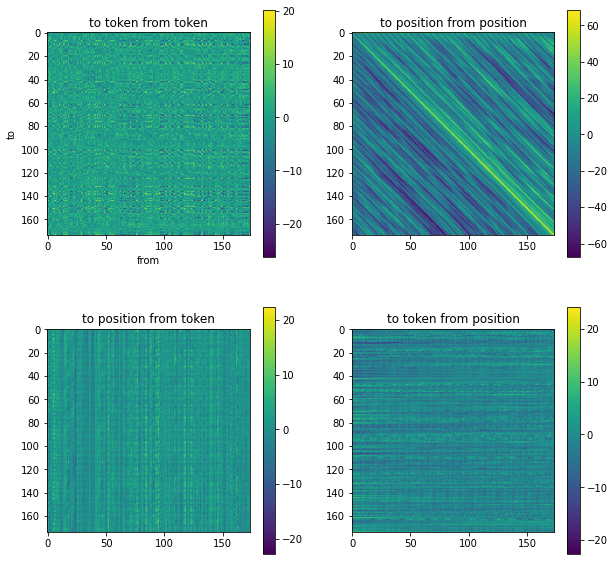

In [93]:
def compute_attention_scores(head_no):
    tokens = test_tokens
    token_embeddings = model.token_embedding(tokens)
    positions = t.arange(512)
    position_embeddings = repeat(model.pos_embedding(positions), 's e -> b s e', b=2048)



    def compute_attention(to_embeddings, from_embeddings):
        q_vals = einsum('b s e, p  e -> b s p', to_embeddings, qs[head_no])
        k_vals = einsum('b s e, p e -> b s p', from_embeddings, ks[head_no])
        attention = einsum('b t p, b f p -> b t f', q_vals, k_vals)
        return attention


    with t.no_grad():
        tok_tok = compute_attention(token_embeddings, token_embeddings)
        pos_pos = compute_attention(position_embeddings, position_embeddings)
        pos_tok = compute_attention(position_embeddings, token_embeddings)
        tok_pos = compute_attention(token_embeddings, position_embeddings)

    return tok_tok, pos_pos, pos_tok, tok_pos
    
def compute_attention_scores_individually(head_no, sentence_no, unpad=False):
    tokens = test_tokens[sentence_no]
    if unpad:
        #get index of first occurrence of token 50258
        pad_idx = list(tokens).index(50258) if 50258 in list(tokens) else -1
        tokens = tokens[:pad_idx]

    token_embeddings = model.token_embedding(tokens)
    positions = t.arange(len(tokens))
    position_embeddings = model.pos_embedding(positions)

    with t.no_grad():
        tok_tok = token_embeddings @ qs[head_no].t() @ ks[head_no] @ token_embeddings.t()
        pos_pos = position_embeddings @ qs[head_no].t() @ ks[head_no] @ position_embeddings.t()
        pos_tok = position_embeddings @ qs[head_no].t() @ ks[head_no] @ token_embeddings.t()
        tok_pos = token_embeddings @ qs[head_no].t() @ ks[head_no] @ position_embeddings.t()
        

    return tok_tok, pos_pos, pos_tok, tok_pos

def visualize_2d(tok_tok, pos_pos, pos_tok, tok_pos):

    # make plot with 2*2 subplots
    fig, axs = plt.subplots(2, 2)

    #set figure size
    fig.set_size_inches(10, 10)

    # plot the first subplot
    axs[0, 0].imshow(tok_tok.numpy())
    axs[0, 0].set_title("to token from token")
    # set x label
    axs[0, 0].set_xlabel("from")
    axs[0, 0].set_ylabel("to")

    axs[0, 1].imshow(pos_pos.numpy())
    axs[0, 1].set_title("to position from position")

    axs[1, 0].imshow(pos_tok.numpy())
    axs[1, 0].set_title("to position from token")

    axs[1, 1].imshow(tok_pos.numpy())
    axs[1, 1].set_title("to token from position")

    #add colorbar
    fig.colorbar(plt.imshow(tok_tok.numpy()), ax=axs[0, 0])
    fig.colorbar(plt.imshow(pos_pos), ax=axs[0, 1])
    fig.colorbar(plt.imshow(pos_tok), ax=axs[1, 0])
    fig.colorbar(plt.imshow(tok_pos), ax=axs[1, 1])



visualize_2d(*compute_attention_scores_individually(0,0, unpad=True))

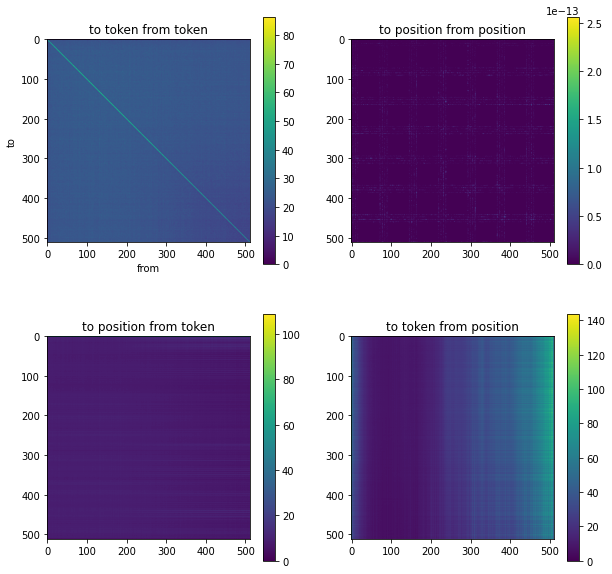

In [115]:
def variances(head_no, per='sentence'):

    tok_tok, pos_pos, pos_tok, tok_pos = compute_attention_scores(head_no)
    assert tok_tok.shape == t.Size([2048, 512, 512])
    dim=None
    if per == 'sentence':
        dim=0
    elif per == 'to_token':
        dim=1
    elif per == 'from_token':
        dim=2
    elif per == 'all':
        dim=[0,1,2]
    else:
        raise ValueError("per must be one of 'sentence', 'to_token', 'from_token', 'all'")
    return tok_tok.var(dim=dim), pos_pos.var(dim=dim), pos_tok.var(dim=dim), tok_pos.var(dim=dim)

tok_tok_var, pos_pos_var, pos_tok_var, tok_pos_var = variances(0, per='sentence')

visualize_2d(tok_tok_var, pos_pos_var, pos_tok_var, tok_pos_var)



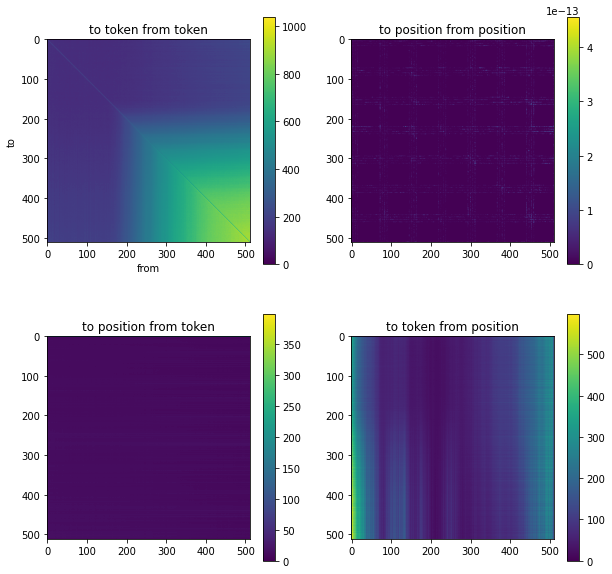

In [94]:
visualize_2d(*variances(head_no=1, per='sentence'))

In [ ]:
all_variances = [variances(head_no=i, per='all') for i in range(8)]
labels=['tok_tok', 'pos_pos', 'pos_tok', 'tok_pos']
heads=np.arange(8)

In [ ]:
#plot each element in all_variances as a series

arr = np.array(all_variances)
fig, ax = plt.subplots()
for i in range(4):
    ax.bar(heads, height=arr[:,i])



KeyboardInterrupt: 

TypeError: only size-1 arrays can be converted to Python scalars

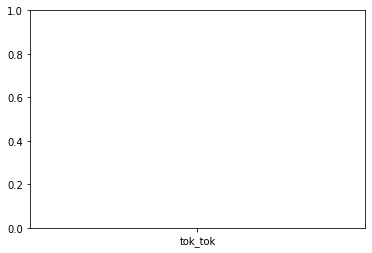

In [120]:
plt.bar(labels, [[0,1, 2, 3], [22,2,2,2]])

In [106]:
print(pos_tok_var[0,507])

tensor(398.5479)
